In [1]:
import numpy as np
import pandas as pd
import statsmodels.formula.api as smf
import matplotlib.pyplot as plt


## Data preparation

In [2]:
# df_gdp = pd.read_csv("../gdp_analysis/results/gdp_weighted_pop_fifty.csv")
df_gdp = pd.read_csv("data/gdp_weighted_pop_decade.csv")
df_gdp = df_gdp.rename(columns={"region": "region_name"})

In [3]:


#df_cultura = pd.read_csv("../unseen_species_model/results/occupation/raw_results.csv", index_col = [0])
#df_cultura = pd.read_csv("../unseen_species_model/results_50/raw_results.csv", index_col = [0])

# Load Unseen-species data
# path = 'unseen_species_model/unseen_species_model.csv'
# path = 'unseen_species_model/unseen_species_model_no_occupation.csv'

path = '../3-unseen_species_index/unseen_species_model/unseen_species_model_bayesian.csv'

df_cultura = pd.read_csv(path, index_col = [0])
# df_cultura = df_cultura.rename(columns = {'f0_min':'min_f0', 'f0_max':'max_f0'})

df_cultura['N_est'] = df_cultura['f0'] + df_cultura['f1'] + df_cultura['f2']# plus the individual
df_cultura = df_cultura.groupby(['region_name', 'decade']).agg({'N_est': 'sum', 'individual_wikidata_id':'count'}).reset_index()
df_cultura = df_cultura.rename(columns={"individual_wikidata_id": "score"})
df_cultura['survival_ratio'] = df_cultura['score']/df_cultura['N_est']


df = pd.merge(df_gdp, df_cultura, on = ['region_name', 'decade'])
df = df.rename(columns = {'decade': 'year', 'gdp_pc_weighted':'gdp_per_capita'})


df['score_cap'] = df['score']/df['pop']
df['N_est_cap'] = df['N_est']/df['pop']


list(set(df.region_name))
df.region_name.value_counts()

keep = ['Indian world',
 'Nordic countries',
 'Persian world',
 'Portugal',
 'United Kingdom',
 'France',
 'Greek World',
 'Arabic world',
 'Chinese world',
 'Japan',
 'German world',
 'Low countries',
 'Italy',
 'Korea',
 'Spain']

# Apply normalization


from scipy import stats
df["century"] = df["year"].round(-2)
df["score_log"] = np.log(df["score"])
df["score_cap_log"] = np.log(df["score_cap"])

df["N_est_log"] = np.log(df["N_est"])
df["N_est_cap_log"] = np.log(df["N_est_cap"])
df["score_log_std"] = df["score_log"] / df["score_log"].mean()


df["score_cap_log_std"] = np.log(df["score_cap"]) / df["score_cap_log"].mean()


df["N_est_std"] = stats.zscore(df["N_est"])  # Z-score 
df["N_est_log_std"] = stats.zscore(df["N_est_log"])  # Z-score
# df["N_est_log_std"] = stats.zscore(df["N_est"])  # Z-score



# df["N_est_std"] = df["N_est"] / df["N_est"].mean()
# df["N_est_log_std"] = df["N_est_log"] / df["N_est_log"].mean()

df["N_est_cap_log_std"] = np.log(df["N_est_cap"]) / df["N_est_cap_log"].mean()
# df["N_est_cap_log_std"] = stats.zscore(df["gdp_per_capita"])  # Z-score


df["log_gdp"] = np.log(df["gdp_per_capita"])

# df["log_gdp_std"] = df["log_gdp"] / df["log_gdp"].mean()
df[f"log_gdp_std"] = stats.zscore(df["log_gdp"])  # Z-score


df["gdp_std"] = df["gdp_per_capita"] / df["gdp_per_capita"].mean()
df["survival_ratio_std"] = df["survival_ratio"] / df["survival_ratio"].mean()

df['pop_log'] =  np.log(df["pop"])
# df["pop_log_std"] = df["pop_log"] / df["pop_log"].mean()

df["pop_log_std"] = stats.zscore(df["pop_log"])  # Z-score


# N_est calculations
df["N_est_log"] = np.log(df["N_est"])


# Variable calculations
#df[f"log_{var}_std"] = stats.zscore(df[f"log_{var}"])  # Z-score



          Mixed Linear Model Regression Results
Model:            MixedLM Dependent Variable: log_gdp_std
No. Observations: 514     Method:             REML       
No. Groups:       16      Scale:              0.2608     
Min. group size:  1       Log-Likelihood:     -416.2349  
Max. group size:  64      Converged:          Yes        
Mean group size:  32.1                                   
---------------------------------------------------------
               Coef.  Std.Err.   z    P>|z| [0.025 0.975]
---------------------------------------------------------
Intercept      -0.255    0.193 -1.319 0.187 -0.633  0.124
N_est_log_std   0.472    0.030 15.802 0.000  0.414  0.531
Group Var       0.560    0.429                           



(0.0, 1.0, 0.0, 1.0)

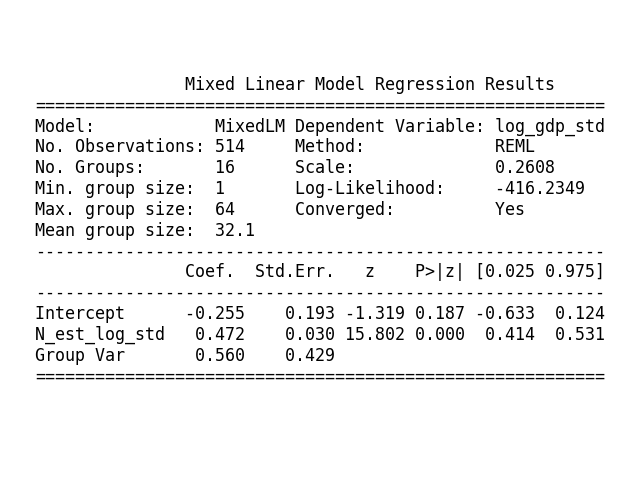

In [4]:
tables_dict = {}

df_ols = df[['region_name', 'year', 'log_gdp_std', 'N_est_log_std', 'score_log_std', 'pop_log_std']].copy()


# Mixed Effects Model
model = smf.mixedlm("log_gdp_std ~ N_est_log_std", df_ols, groups=df_ols["region_name"])
result = model.fit()


sm_table = result.summary().tables[1]
sm_table.index = ['Intercept', 'alpha', 'Group Var']
sm_table['model'] = 'Corrected CPI'
sm_table = sm_table.reset_index()
tables_dict['Corrected CPI'] = sm_table


# Output model summary to get R-square values if available (typically for OLS, not directly for MixedLM)
print(result.summary())


# Plotting the summary text
fig, ax = plt.subplots(figsize=(8, 6))
ax.text(0.5, 0.5, result.summary(), fontsize=12, va='center', ha='center', fontname='Monospace')
ax.axis('off')  # Turn off the axis

# plt.savefig('model_summary.png', dpi=300, bbox_inches='tight', pad_inches=0.5)


#### Proper Regression Table

In [5]:
import matplotlib.pyplot as plt
import pandas as pd

# Assuming the dataframe 'df_ols' is correctly set up from previous examples and ready to use
# Fit Mixed Effects Model (with region as a random effect)
mixed_model = smf.mixedlm("log_gdp_std ~ N_est_log_std", df_ols, groups=df_ols["region_name"])
result_mixed = mixed_model.fit()

# Fit OLS Model (without fixed effects)
ols_model = smf.ols("log_gdp_std ~ N_est_log_std", df_ols)
result_ols = ols_model.fit()


# Calculate the correlation coefficient for the OLS model (without fixed effects)
correlation_ols = df_ols['log_gdp_std'].corr(df_ols['N_est_log_std'])

# Calculate correlation coefficients for each group in the mixed effects model and take the average
grouped = df_ols.groupby('region_name')
correlation_mixed = grouped.apply(lambda g: g['log_gdp_std'].corr(g['N_est_log_std'])).mean()


# Calculate R-squared for OLS model
r_squared_ols = result_ols.rsquared

# Calculate pseudo-R-squared for Mixed Model


# Assuming the model results and other variables (correlation_ols, correlation_mixed, etc.) are already available
results_df = pd.DataFrame({
    'Model': ['OLS Without FE', 'MixedLM With FE'],
    'Intercept': [f"{result_ols.params['Intercept']:.2f} ({result_ols.bse['Intercept']:.2f})", 
                  f"{result_mixed.params['Intercept']:.2f} ({result_mixed.bse['Intercept']:.2f})"],
    'CPI Coef': [f"{result_ols.params['N_est_log_std']:.2f} ({result_ols.bse['N_est_log_std']:.2f})", 
                 f"{result_mixed.params['N_est_log_std']:.2f} ({result_mixed.bse['N_est_log_std']:.2f})"],
    'CPI p-value': [f"{result_ols.pvalues['N_est_log_std']:.2f}", f"{result_mixed.pvalues['N_est_log_std']:.2f}"],
    'Log-Likelihood': [f"{result_ols.llf:.2f}", f"{result_mixed.llf:.2f}"],
    'Correlation': [f"{correlation_ols:.2f}", f"{correlation_mixed:.2f}"],
    'N': [f"{result_ols.nobs}", f"{result_mixed.nobs}"],
    'R-squared': [f"{result_ols.rsquared:.2f}", "N/A"]
})

# Transpose the DataFrame for the desired format
results_df = results_df.T
results_df.columns = results_df.iloc[0]  # Set the first row as column headers
results_df = results_df[1:]  # Remove the first row as it's now redundant

results_df

/Users/charlesdedampierre/Desktop/cultura_project/.venv/lib/python3.11/site-packages/numpy/lib/function_base.py:2889: RuntimeWarning: Degrees of freedom <= 0 for slice
  c = cov(x, y, rowvar, dtype=dtype)
/Users/charlesdedampierre/Desktop/cultura_project/.venv/lib/python3.11/site-packages/numpy/lib/function_base.py:2748: RuntimeWarning: divide by zero encountered in divide
  c *= np.true_divide(1, fact)
/Users/charlesdedampierre/Desktop/cultura_project/.venv/lib/python3.11/site-packages/numpy/lib/function_base.py:2748: RuntimeWarning: invalid value encountered in multiply
  c *= np.true_divide(1, fact)


Model,OLS Without FE,MixedLM With FE
Intercept,0.00 (0.04),-0.25 (0.19)
CPI Coef,0.50 (0.04),0.47 (0.03)
CPI p-value,0.00,0.00
Log-Likelihood,-655.67,-416.23
Correlation,0.50,0.46
N,514.0,514
R-squared,0.25,N/A


### Regression table (to mix with HDI measdures)

In [6]:
import matplotlib.pyplot as plt
import pandas as pd
import statsmodels.formula.api as smf

# Assuming the dataframe 'df_ols' is correctly set up from previous examples and ready to use
# Variable 'var' needs to be defined (e.g., var = 'some_variable_name')


var = 'gdp'

# df_ols.drop('score_log_std', axis=1).to_csv(f'df_indicators_hdi/data_for_regression/{var}.csv')

# Fit Mixed Effects Model (with region as a random effect)
mixed_model = smf.mixedlm(f"log_{var}_std ~ N_est_log_std", df_ols, groups=df_ols["region_name"])
result_mixed = mixed_model.fit()

# Fit OLS Model (without fixed effects)
ols_model = smf.ols(f"log_{var}_std ~ N_est_log_std", df_ols)
result_ols = ols_model.fit()

# Calculate the correlation coefficient for the OLS model (without fixed effects)
correlation_ols = df_ols['N_est_log_std'].corr(df_ols[f"log_{var}_std"])

# Calculate correlation coefficients for each group in the mixed effects model and take the average
grouped = df_ols.groupby('region_name')
correlation_mixed = grouped.apply(lambda g: g['N_est_log_std'].corr(g[f"log_{var}_std"])).mean()

# Prepare the results dataframe
results_df = pd.DataFrame({
    'Model': ['OLS Without FE', 'MixedLM With FE'],
    'Intercept': [f"{result_ols.params['Intercept']:.2f}", f"{result_mixed.params['Intercept']:.2f}"],
    'Intercept_SE': [f"{result_ols.bse['Intercept']:.2f}", f"{result_mixed.bse['Intercept']:.2f}"],
    'Intercept_CI': [f"({result_ols.conf_int().loc['Intercept'][0]:.2f}, {result_ols.conf_int().loc['Intercept'][1]:.2f})", 
                     f"({result_mixed.conf_int().loc['Intercept'][0]:.2f}, {result_mixed.conf_int().loc['Intercept'][1]:.2f})"],
    'Intercept_t-value': [f"{result_ols.tvalues['Intercept']:.2f}", f"{result_mixed.tvalues['Intercept']:.2f}"],
    'Coef': [f"{result_ols.params['N_est_log_std']:.2f}", f"{result_mixed.params['N_est_log_std']:.2f}"],
    'Coef_SE': [f"{result_ols.bse['N_est_log_std']:.2f}", f"{result_mixed.bse['N_est_log_std']:.2f}"],
    'Coef_CI': [f"({result_ols.conf_int().loc['N_est_log_std'][0]:.2f}, {result_ols.conf_int().loc['N_est_log_std'][1]:.2f})", 
                f"({result_mixed.conf_int().loc['N_est_log_std'][0]:.2f}, {result_mixed.conf_int().loc['N_est_log_std'][1]:.2f})"],
    'Coef_t-value': [f"{result_ols.tvalues['N_est_log_std']:.2f}", f"{result_mixed.tvalues['N_est_log_std']:.2f}"],
    'Coef_p-value': [f"{result_ols.pvalues['N_est_log_std']:.3f}", f"{result_mixed.pvalues['N_est_log_std']:.3f}"],
    'Log-Likelihood': [f"{result_ols.llf:.2f}", f"{result_mixed.llf:.2f}"],
    'Correlation': [f"{correlation_ols:.2f}", f"{correlation_mixed:.2f}"],
    'N': [f"{result_ols.nobs:.0f}", f"{result_mixed.nobs:.0f}"],
    'R-squared': [f"{result_ols.rsquared:.2f}", "N/A"]
})

# Transpose the DataFrame for the desired format and add variable name
results_df = results_df.T
results_df.columns = results_df.iloc[0]  # Set the first row as column headers
results_df = results_df[1:]  # Remove the first row as it's now redundant
results_df['Variable'] = var

# Save the results to a CSV file
results_df.to_csv(f'data/regression_table_{var}.csv')

# Print the results
results_df


/Users/charlesdedampierre/Desktop/cultura_project/.venv/lib/python3.11/site-packages/numpy/lib/function_base.py:2889: RuntimeWarning: Degrees of freedom <= 0 for slice
  c = cov(x, y, rowvar, dtype=dtype)
/Users/charlesdedampierre/Desktop/cultura_project/.venv/lib/python3.11/site-packages/numpy/lib/function_base.py:2748: RuntimeWarning: divide by zero encountered in divide
  c *= np.true_divide(1, fact)
/Users/charlesdedampierre/Desktop/cultura_project/.venv/lib/python3.11/site-packages/numpy/lib/function_base.py:2748: RuntimeWarning: invalid value encountered in multiply
  c *= np.true_divide(1, fact)


Model,OLS Without FE,MixedLM With FE,Variable
Intercept,0.00,-0.25,gdp
Intercept_SE,0.04,0.19,gdp
Intercept_CI,"(-0.08, 0.08)","(-0.63, 0.12)",gdp
Intercept_t-value,0.00,-1.32,gdp
Coef,0.50,0.47,gdp
Coef_SE,0.04,0.03,gdp
Coef_CI,"(0.42, 0.57)","(0.41, 0.53)",gdp
Coef_t-value,13.04,15.80,gdp
Coef_p-value,0.000,0.000,gdp
Log-Likelihood,-655.67,-416.23,gdp


### Proper table with population Data

In [7]:
import matplotlib.pyplot as plt
import pandas as pd
import statsmodels.formula.api as smf

# Assuming the dataframe 'df_ols' is correctly set up from previous examples and ready to use
# Variable 'var' needs to be defined (e.g., var = 'some_variable_name')


var = 'gdp'

# df_ols.drop('score_log_std', axis=1).to_csv(f'df_indicators_hdi/data_for_regression/{var}.csv')

# Fit Mixed Effects Model (with region as a random effect)
mixed_model = smf.mixedlm(f"log_{var}_std ~ N_est_log_std + pop_log_std", df_ols, groups=df_ols["region_name"])
result_mixed = mixed_model.fit()

# Fit OLS Model (without fixed effects)
ols_model = smf.ols(f"log_{var}_std ~ N_est_log_std", df_ols)
result_ols = ols_model.fit()

# Calculate the correlation coefficient for the OLS model (without fixed effects)
correlation_ols = df_ols['N_est_log_std'].corr(df_ols[f"log_{var}_std"])

# Calculate correlation coefficients for each group in the mixed effects model and take the average
grouped = df_ols.groupby('region_name')
correlation_mixed = grouped.apply(lambda g: g['N_est_log_std'].corr(g[f"log_{var}_std"])).mean()

# Prepare the results dataframe
results_df = pd.DataFrame({
    'Model': ['OLS Without FE', 'MixedLM With FE'],
    'Intercept': [f"{result_ols.params['Intercept']:.2f}", f"{result_mixed.params['Intercept']:.2f}"],
    'Intercept_SE': [f"{result_ols.bse['Intercept']:.2f}", f"{result_mixed.bse['Intercept']:.2f}"],
    'Intercept_CI': [f"({result_ols.conf_int().loc['Intercept'][0]:.2f}, {result_ols.conf_int().loc['Intercept'][1]:.2f})", 
                     f"({result_mixed.conf_int().loc['Intercept'][0]:.2f}, {result_mixed.conf_int().loc['Intercept'][1]:.2f})"],
    'Intercept_t-value': [f"{result_ols.tvalues['Intercept']:.2f}", f"{result_mixed.tvalues['Intercept']:.2f}"],
    'Coef': [f"{result_ols.params['N_est_log_std']:.2f}", f"{result_mixed.params['N_est_log_std']:.2f}"],
    'Coef_SE': [f"{result_ols.bse['N_est_log_std']:.2f}", f"{result_mixed.bse['N_est_log_std']:.2f}"],
    'Coef_CI': [f"({result_ols.conf_int().loc['N_est_log_std'][0]:.2f}, {result_ols.conf_int().loc['N_est_log_std'][1]:.2f})", 
                f"({result_mixed.conf_int().loc['N_est_log_std'][0]:.2f}, {result_mixed.conf_int().loc['N_est_log_std'][1]:.2f})"],
    'Coef_t-value': [f"{result_ols.tvalues['N_est_log_std']:.2f}", f"{result_mixed.tvalues['N_est_log_std']:.2f}"],
    'Coef_p-value': [f"{result_ols.pvalues['N_est_log_std']:.3f}", f"{result_mixed.pvalues['N_est_log_std']:.3f}"],
    'Log-Likelihood': [f"{result_ols.llf:.2f}", f"{result_mixed.llf:.2f}"],
    'Correlation': [f"{correlation_ols:.2f}", f"{correlation_mixed:.2f}"],
    'N': [f"{result_ols.nobs:.0f}", f"{result_mixed.nobs:.0f}"],
    'R-squared': [f"{result_ols.rsquared:.2f}", "N/A"]
})

# Transpose the DataFrame for the desired format and add variable name
results_df = results_df.T
results_df.columns = results_df.iloc[0]  # Set the first row as column headers
results_df = results_df[1:]  # Remove the first row as it's now redundant
results_df['Variable'] = var

# Save the results to a CSV file
#results_df.to_csv(f'data/regression_table_{var}.csv')

# Print the results
results_df.to_csv(f'data/regression_table_{var}_pop.csv')


/Users/charlesdedampierre/Desktop/cultura_project/.venv/lib/python3.11/site-packages/numpy/lib/function_base.py:2889: RuntimeWarning: Degrees of freedom <= 0 for slice
  c = cov(x, y, rowvar, dtype=dtype)
/Users/charlesdedampierre/Desktop/cultura_project/.venv/lib/python3.11/site-packages/numpy/lib/function_base.py:2748: RuntimeWarning: divide by zero encountered in divide
  c *= np.true_divide(1, fact)
/Users/charlesdedampierre/Desktop/cultura_project/.venv/lib/python3.11/site-packages/numpy/lib/function_base.py:2748: RuntimeWarning: invalid value encountered in multiply
  c *= np.true_divide(1, fact)


                            OLS Regression Results                            
Dep. Variable:            log_gdp_std   R-squared:                       0.249
Model:                            OLS   Adj. R-squared:                  0.248
Method:                 Least Squares   F-statistic:                     169.9
Date:                Sat, 17 May 2025   Prob (F-statistic):           9.56e-34
Time:                        13:54:20   Log-Likelihood:                -655.67
No. Observations:                 514   AIC:                             1315.
Df Residuals:                     512   BIC:                             1324.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
Intercept      3.065e-15      0.038      8e-14

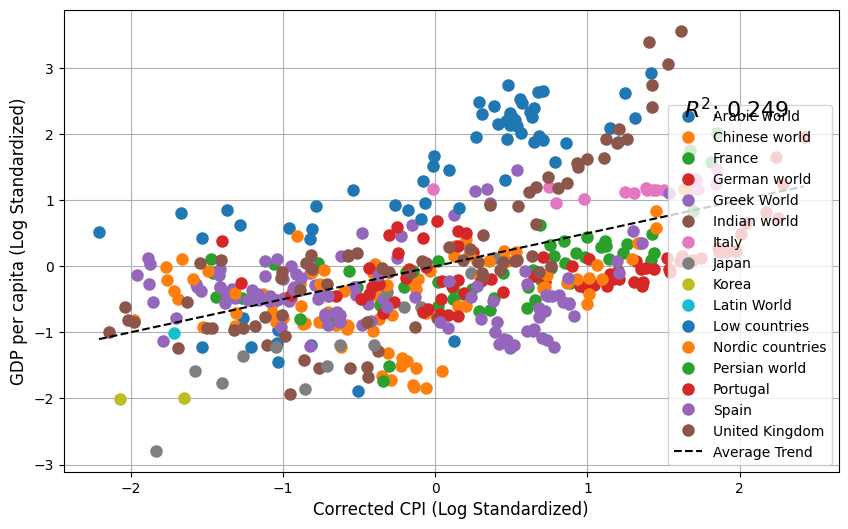

In [8]:


# Fitting an OLS model to obtain a single average trend line across all data
average_ols_model = smf.ols("log_gdp_std ~ N_est_log_std", data=df_ols).fit()
#average_ols_model = smf.mixedlm("log_gdp_std ~ N_est_log_std", df_ols, groups=df_ols["region_name"]).fit()
print(average_ols_model.summary())

# Prepare plot for relationship with a single average trend line
plt.figure(figsize=(10, 6))
for name, group in df_ols.groupby('region_name'):
    plt.plot(group['N_est_log_std'], group['log_gdp_std'], marker='o', linestyle='', ms=8, label=name)

# Calculate the average trend line across all data
x_vals = np.linspace(df_ols['N_est_log_std'].min(), df_ols['N_est_log_std'].max(), 100)
y_vals = average_ols_model.params['Intercept'] + average_ols_model.params['N_est_log_std'] * x_vals
plt.plot(x_vals, y_vals, 'k--', label='Average Trend')

plt.legend()
plt.xlabel('Corrected CPI (Log Standardized)', fontsize=12)
plt.ylabel('GDP per capita (Log Standardized)', fontsize=12)
plt.title('')
plt.grid(True)

# Show R-squared on the plot for the average trend line
r_squared = average_ols_model.rsquared
plt.figtext(0.85, 0.7, f'$R^2$: {r_squared:.3f}', ha='right', fontsize=16)

plt.show()

/var/folders/lx/9b13r6ln63jb54_3xlf9b_380000gn/T/ipykernel_76234/1590067226.py:19: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "k--" (-> color='k'). The keyword argument will take precedence.
  plt.plot(x_vals, y_vals, 'k--', color=color_map[name], label=None)
/var/folders/lx/9b13r6ln63jb54_3xlf9b_380000gn/T/ipykernel_76234/1590067226.py:19: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "k--" (-> color='k'). The keyword argument will take precedence.
  plt.plot(x_vals, y_vals, 'k--', color=color_map[name], label=None)
/var/folders/lx/9b13r6ln63jb54_3xlf9b_380000gn/T/ipykernel_76234/1590067226.py:19: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "k--" (-> color='k'). The keyword argument will take precedence.
  plt.plot(x_vals, y_vals, 'k--', color=color_map[name], label=None)
/var/folders/lx/9b13r6ln63jb54_3xlf9b_380000gn/T/ipykernel_76234/15900

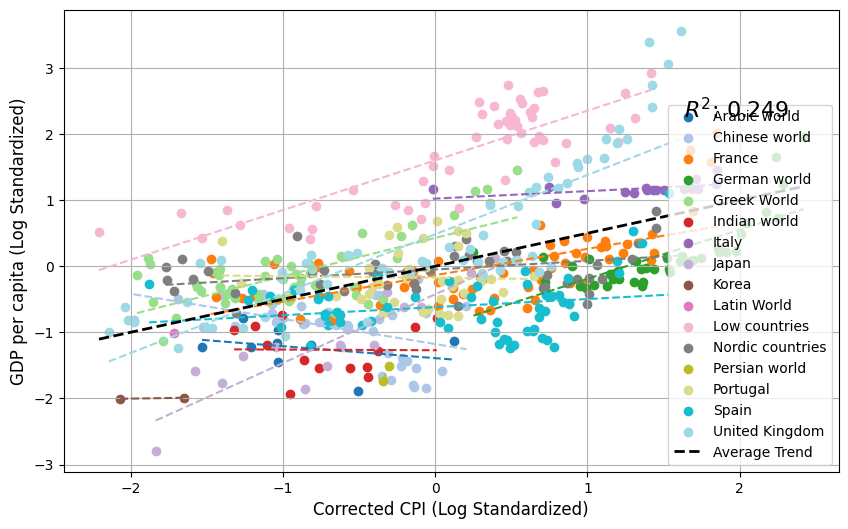

In [9]:

cmap = plt.get_cmap('tab20')
unique_regions = df_ols['region_name'].unique()
colors = cmap(np.linspace(0, 1, len(unique_regions)))
color_map = dict(zip(unique_regions, colors))

plt.figure(figsize=(10, 6))

# Plot individual data points and fit a regression line for each region
for name, group in df_ols.groupby('region_name'):
    # Fit OLS model for each region
    individual_ols_model = smf.ols("log_gdp_std ~ N_est_log_std", data=group).fit()
    
    # Plotting the scatter for each group
    plt.scatter(group['N_est_log_std'], group['log_gdp_std'], color=color_map[name], label=name)
    
    # Calculating the regression line
    x_vals = np.linspace(group['N_est_log_std'].min(), group['N_est_log_std'].max(), 100)
    y_vals = individual_ols_model.params['Intercept'] + individual_ols_model.params['N_est_log_std'] * x_vals
    plt.plot(x_vals, y_vals, 'k--', color=color_map[name], label=None)

# Fit a global OLS model to get the average trend line
average_ols_model = smf.ols("log_gdp_std ~ N_est_log_std", data=df_ols).fit()

# Calculate and plot the average trend line
x_vals_global = np.linspace(df_ols['N_est_log_std'].min(), df_ols['N_est_log_std'].max(), 100)
y_vals_global = average_ols_model.params['Intercept'] + average_ols_model.params['N_est_log_std'] * x_vals_global
plt.plot(x_vals_global, y_vals_global, 'k--', label='Average Trend', linewidth=2)

plt.legend()
plt.xlabel('Corrected CPI (Log Standardized)', fontsize=12)
plt.ylabel('GDP per capita (Log Standardized)', fontsize=12)
plt.title('')
plt.grid(True)

# Display R-squared for the average trend line
r_squared = average_ols_model.rsquared
plt.figtext(0.85, 0.7, f'$R^2$: {r_squared:.3f}', ha='right', fontsize=16)

plt.show()

## CPI

          Mixed Linear Model Regression Results
Model:            MixedLM Dependent Variable: log_gdp_std
No. Observations: 514     Method:             REML       
No. Groups:       16      Scale:              0.2452     
Min. group size:  1       Log-Likelihood:     -400.6115  
Max. group size:  64      Converged:          Yes        
Mean group size:  32.1                                   
---------------------------------------------------------
               Coef.  Std.Err.   z    P>|z| [0.025 0.975]
---------------------------------------------------------
Intercept      -1.138    0.201 -5.661 0.000 -1.532 -0.744
score_log_std   0.871    0.051 17.203 0.000  0.772  0.970
Group Var       0.581    0.457                           



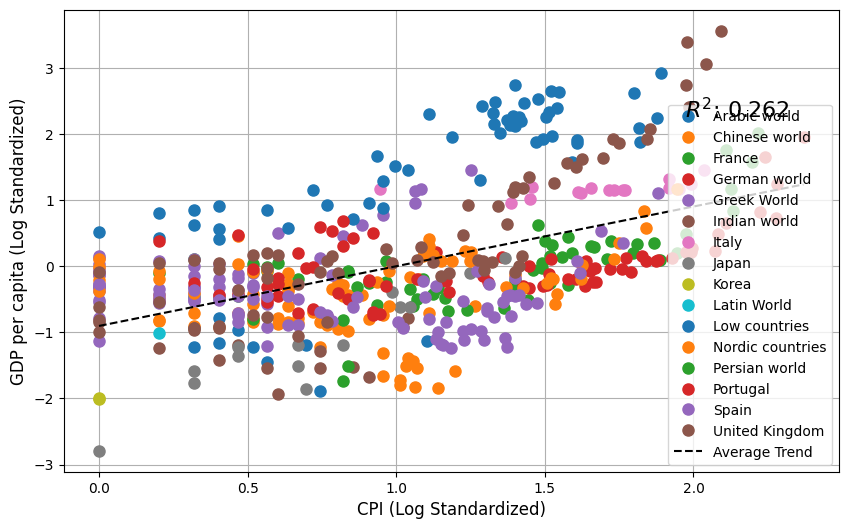

In [10]:
# Mixed Effects Model
model = smf.mixedlm("log_gdp_std ~ score_log_std", df_ols, groups=df_ols["region_name"])
result = model.fit()


sm_table = result.summary().tables[1]
sm_table.index = ['Intercept', 'alpha', 'Group Var']
sm_table['model'] = 'CPI'
sm_table = sm_table.reset_index()
tables_dict['CPI'] = sm_table

# Output model summary to get R-square values if available (typically for OLS, not directly for MixedLM)
print(result.summary())

# Fitting an OLS model to obtain a single average trend line across all data
average_ols_model = smf.ols("log_gdp_std ~ score_log_std", data=df_ols).fit()

# Prepare plot for relationship with a single average trend line
plt.figure(figsize=(10, 6))
for name, group in df_ols.groupby('region_name'):
    plt.plot(group['score_log_std'], group['log_gdp_std'], marker='o', linestyle='', ms=8, label=name)

# Calculate the average trend line across all data
x_vals = np.linspace(df_ols['score_log_std'].min(), df_ols['score_log_std'].max(), 100)
y_vals = average_ols_model.params['Intercept'] + average_ols_model.params['score_log_std'] * x_vals
plt.plot(x_vals, y_vals, 'k--', label='Average Trend')

plt.legend()
plt.xlabel('CPI (Log Standardized)', fontsize=12)
plt.ylabel('GDP per capita (Log Standardized)', fontsize=12)
plt.title('')
plt.grid(True)

# Show R-squared on the plot for the average trend line
r_squared = average_ols_model.rsquared
plt.figtext(0.85, 0.7, f'$R^2$: {r_squared:.3f}', ha='right', fontsize=16)

plt.show()

/var/folders/lx/9b13r6ln63jb54_3xlf9b_380000gn/T/ipykernel_76234/2229280083.py:19: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "k--" (-> color='k'). The keyword argument will take precedence.
  plt.plot(x_vals, y_vals, 'k--', color=color_map[name], label=None)
/var/folders/lx/9b13r6ln63jb54_3xlf9b_380000gn/T/ipykernel_76234/2229280083.py:19: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "k--" (-> color='k'). The keyword argument will take precedence.
  plt.plot(x_vals, y_vals, 'k--', color=color_map[name], label=None)
/var/folders/lx/9b13r6ln63jb54_3xlf9b_380000gn/T/ipykernel_76234/2229280083.py:19: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "k--" (-> color='k'). The keyword argument will take precedence.
  plt.plot(x_vals, y_vals, 'k--', color=color_map[name], label=None)
/var/folders/lx/9b13r6ln63jb54_3xlf9b_380000gn/T/ipykernel_76234/22292

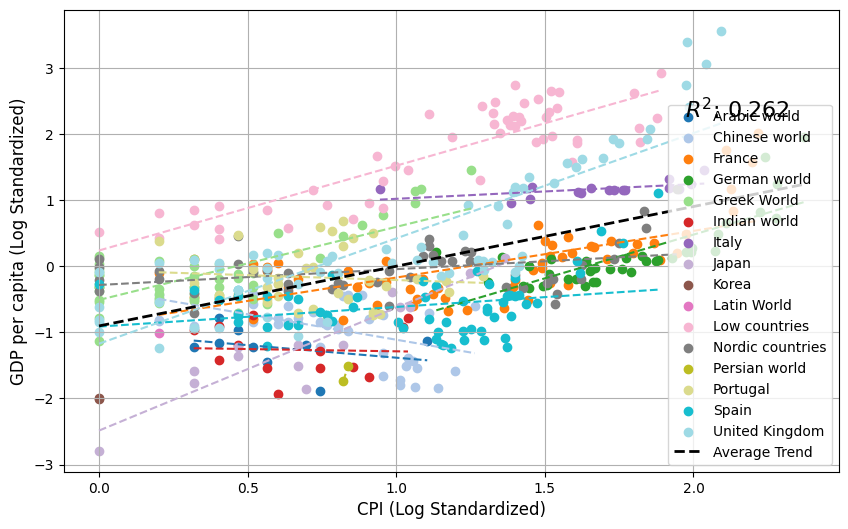

In [11]:

cmap = plt.get_cmap('tab20')
unique_regions = df_ols['region_name'].unique()
colors = cmap(np.linspace(0, 1, len(unique_regions)))
color_map = dict(zip(unique_regions, colors))

plt.figure(figsize=(10, 6))

# Plot individual data points and fit a regression line for each region
for name, group in df_ols.groupby('region_name'):
    # Fit OLS model for each region
    individual_ols_model = smf.ols("log_gdp_std ~ score_log_std", data=group).fit()
    
    # Plotting the scatter for each group
    plt.scatter(group['score_log_std'], group['log_gdp_std'], color=color_map[name], label=name)
    
    # Calculating the regression line
    x_vals = np.linspace(group['score_log_std'].min(), group['score_log_std'].max(), 100)
    y_vals = individual_ols_model.params['Intercept'] + individual_ols_model.params['score_log_std'] * x_vals
    plt.plot(x_vals, y_vals, 'k--', color=color_map[name], label=None)

# Fit a global OLS model to get the average trend line
average_ols_model = smf.ols("log_gdp_std ~ score_log_std", data=df_ols).fit()

# Calculate and plot the average trend line
x_vals_global = np.linspace(df_ols['score_log_std'].min(), df_ols['score_log_std'].max(), 100)
y_vals_global = average_ols_model.params['Intercept'] + average_ols_model.params['score_log_std'] * x_vals_global
plt.plot(x_vals_global, y_vals_global, 'k--', label='Average Trend', linewidth=2)

plt.legend()
plt.xlabel('CPI (Log Standardized)', fontsize=12)
plt.ylabel('GDP per capita (Log Standardized)', fontsize=12)
plt.title('')
plt.grid(True)

# Display R-squared for the average trend line
r_squared = average_ols_model.rsquared
plt.figtext(0.85, 0.7, f'$R^2$: {r_squared:.3f}', ha='right', fontsize=16)

plt.show()

## Corrected CPI 1800-1880

          Mixed Linear Model Regression Results
Model:            MixedLM Dependent Variable: log_gdp_std
No. Observations: 108     Method:             REML       
No. Groups:       15      Scale:              0.1159     
Min. group size:  2       Log-Likelihood:     -66.1897   
Max. group size:  9       Converged:          Yes        
Mean group size:  7.2                                    
---------------------------------------------------------
               Coef.  Std.Err.   z    P>|z| [0.025 0.975]
---------------------------------------------------------
Intercept      -0.593    0.243 -2.441 0.015 -1.070 -0.117
N_est_log_std   1.228    0.120 10.243 0.000  0.993  1.463
Group Var       0.810    0.997                           

                            OLS Regression Results                            
Dep. Variable:            log_gdp_std   R-squared:                       0.514
Model:                            OLS   Adj. R-squared:                  0.510
Method:           

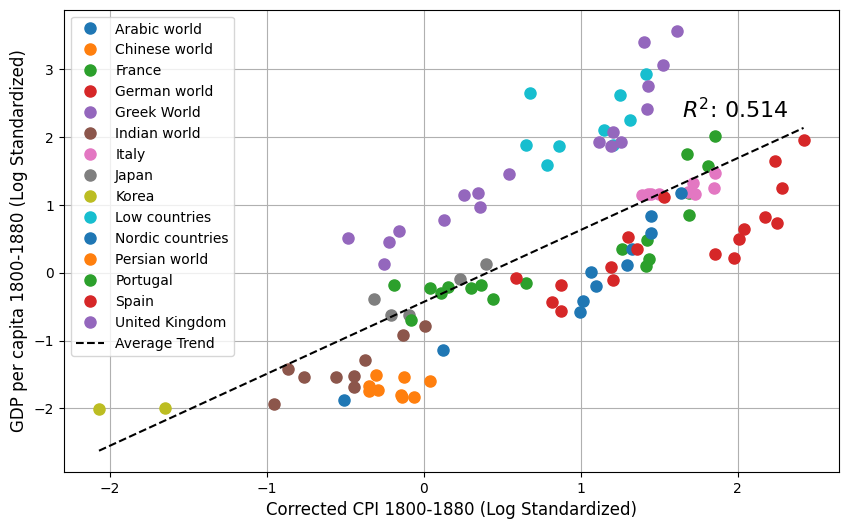

In [12]:
df_ols = df[['region_name', 'year', 'log_gdp_std', 'N_est_log_std', 'score_log_std']].copy()
df_ols = df_ols[df_ols['year']>=1800]
df_ols.region_name.value_counts()

# Mixed Effects Model
model = smf.mixedlm("log_gdp_std ~ N_est_log_std", df_ols, groups=df_ols["region_name"])
result = model.fit()

# Output model summary to get R-square values if available (typically for OLS, not directly for MixedLM)
print(result.summary())

sm_table = result.summary().tables[1]
sm_table.index = ['Intercept', 'alpha', 'Group Var']
sm_table['model'] = 'Corrected CPI 1800-1880'
sm_table = sm_table.reset_index()
tables_dict['Corrected CPI 1800-1880'] = sm_table


# Fitting an OLS model to obtain a single average trend line across all data
average_ols_model = smf.ols("log_gdp_std ~ N_est_log_std", data=df_ols).fit()
#average_ols_model = smf.mixedlm("log_gdp_std ~ N_est_log_std", df_ols, groups=df_ols["region_name"]).fit()
print(average_ols_model.summary())

# Prepare plot for relationship with a single average trend line
plt.figure(figsize=(10, 6))
for name, group in df_ols.groupby('region_name'):
    plt.plot(group['N_est_log_std'], group['log_gdp_std'], marker='o', linestyle='', ms=8, label=name)

# Calculate the average trend line across all data
x_vals = np.linspace(df_ols['N_est_log_std'].min(), df_ols['N_est_log_std'].max(), 100)
y_vals = average_ols_model.params['Intercept'] + average_ols_model.params['N_est_log_std'] * x_vals
plt.plot(x_vals, y_vals, 'k--', label='Average Trend')

plt.legend()
plt.xlabel('Corrected CPI 1800-1880 (Log Standardized)', fontsize=12)
plt.ylabel('GDP per capita 1800-1880 (Log Standardized)', fontsize=12)
plt.title('')
plt.grid(True)

# Show R-squared on the plot for the average trend line
r_squared = average_ols_model.rsquared


plt.figtext(0.85, 0.7, f'$R^2$: {r_squared:.3f}', ha='right', fontsize=16)

plt.show()



/var/folders/lx/9b13r6ln63jb54_3xlf9b_380000gn/T/ipykernel_76234/3500337800.py:19: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "k--" (-> color='k'). The keyword argument will take precedence.
  plt.plot(x_vals, y_vals, 'k--', color=color_map[name], label=None)
/var/folders/lx/9b13r6ln63jb54_3xlf9b_380000gn/T/ipykernel_76234/3500337800.py:19: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "k--" (-> color='k'). The keyword argument will take precedence.
  plt.plot(x_vals, y_vals, 'k--', color=color_map[name], label=None)
/var/folders/lx/9b13r6ln63jb54_3xlf9b_380000gn/T/ipykernel_76234/3500337800.py:19: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "k--" (-> color='k'). The keyword argument will take precedence.
  plt.plot(x_vals, y_vals, 'k--', color=color_map[name], label=None)
/var/folders/lx/9b13r6ln63jb54_3xlf9b_380000gn/T/ipykernel_76234/35003

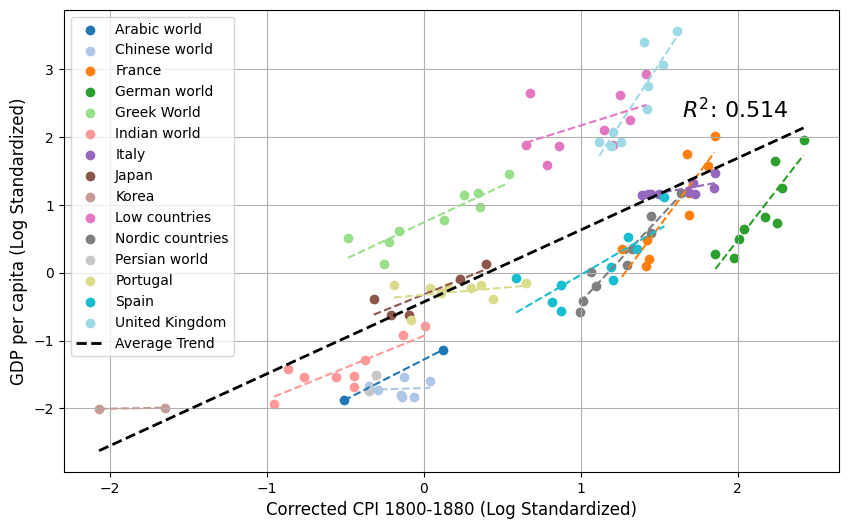

In [13]:

cmap = plt.get_cmap('tab20')
unique_regions = df_ols['region_name'].unique()
colors = cmap(np.linspace(0, 1, len(unique_regions)))
color_map = dict(zip(unique_regions, colors))

plt.figure(figsize=(10, 6))

# Plot individual data points and fit a regression line for each region
for name, group in df_ols.groupby('region_name'):
    # Fit OLS model for each region
    individual_ols_model = smf.ols("log_gdp_std ~ N_est_log_std", data=group).fit()
    
    # Plotting the scatter for each group
    plt.scatter(group['N_est_log_std'], group['log_gdp_std'], color=color_map[name], label=name)
    
    # Calculating the regression line
    x_vals = np.linspace(group['N_est_log_std'].min(), group['N_est_log_std'].max(), 100)
    y_vals = individual_ols_model.params['Intercept'] + individual_ols_model.params['N_est_log_std'] * x_vals
    plt.plot(x_vals, y_vals, 'k--', color=color_map[name], label=None)

# Fit a global OLS model to get the average trend line
average_ols_model = smf.ols("log_gdp_std ~ N_est_log_std", data=df_ols).fit()

# Calculate and plot the average trend line
x_vals_global = np.linspace(df_ols['N_est_log_std'].min(), df_ols['N_est_log_std'].max(), 100)
y_vals_global = average_ols_model.params['Intercept'] + average_ols_model.params['N_est_log_std'] * x_vals_global
plt.plot(x_vals_global, y_vals_global, 'k--', label='Average Trend', linewidth=2)

plt.legend()
plt.xlabel('Corrected CPI 1800-1880 (Log Standardized)', fontsize=12)
plt.ylabel('GDP per capita (Log Standardized)', fontsize=12)
plt.title('')
plt.grid(True)

# Display R-squared for the average trend line
r_squared = average_ols_model.rsquared
plt.figtext(0.85, 0.7, f'$R^2$: {r_squared:.3f}', ha='right', fontsize=16)

plt.show()

## CPI 1800-1880

          Mixed Linear Model Regression Results
Model:            MixedLM Dependent Variable: log_gdp_std
No. Observations: 108     Method:             REML       
No. Groups:       15      Scale:              0.1212     
Min. group size:  2       Log-Likelihood:     -67.3713   
Max. group size:  9       Converged:          Yes        
Mean group size:  7.2                                    
---------------------------------------------------------
               Coef.  Std.Err.   z    P>|z| [0.025 0.975]
---------------------------------------------------------
Intercept      -2.549    0.343 -7.432 0.000 -3.222 -1.877
score_log_std   1.950    0.194 10.059 0.000  1.570  2.330
Group Var       0.760    0.908                           

                            OLS Regression Results                            
Dep. Variable:            log_gdp_std   R-squared:                       0.529
Model:                            OLS   Adj. R-squared:                  0.525
Method:           

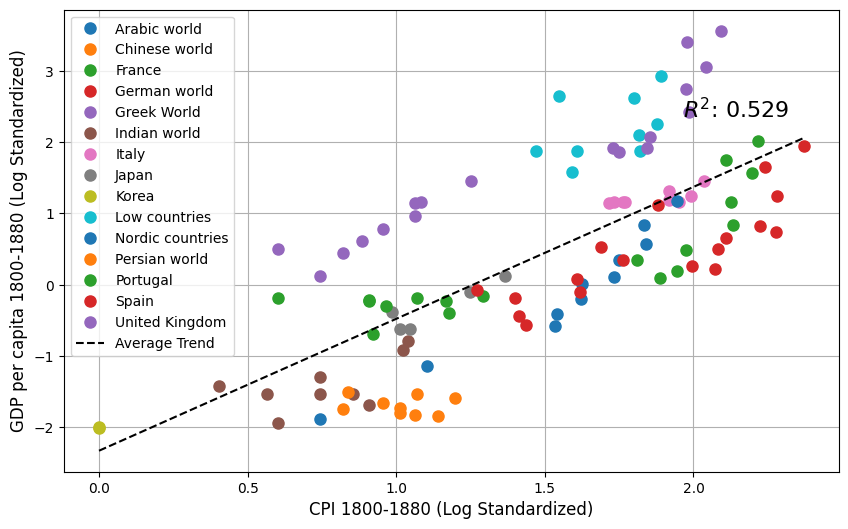

In [14]:
df_ols = df[['region_name', 'year', 'log_gdp_std', 'N_est_log_std', 'score_log_std']].copy()
df_ols = df_ols[df_ols['year']>=1800]
df_ols.region_name.value_counts()

# Mixed Effects Model
model = smf.mixedlm("log_gdp_std ~ score_log_std", df_ols, groups=df_ols["region_name"])
result = model.fit()

# Output model summary to get R-square values if available (typically for OLS, not directly for MixedLM)
print(result.summary())

sm_table = result.summary().tables[1]
sm_table.index = ['Intercept', 'alpha', 'Group Var']
sm_table['model'] = 'CPI 1800-1880'
sm_table = sm_table.reset_index()
tables_dict['CPI 1800-1880'] = sm_table


# Fitting an OLS model to obtain a single average trend line across all data
average_ols_model = smf.ols("log_gdp_std ~ score_log_std", data=df_ols).fit()
#average_ols_model = smf.mixedlm("log_gdp_std ~ N_est_log_std", df_ols, groups=df_ols["region_name"]).fit()
print(average_ols_model.summary())

# Prepare plot for relationship with a single average trend line
plt.figure(figsize=(10, 6))
for name, group in df_ols.groupby('region_name'):
    plt.plot(group['score_log_std'], group['log_gdp_std'], marker='o', linestyle='', ms=8, label=name)

# Calculate the average trend line across all data
x_vals = np.linspace(df_ols['score_log_std'].min(), df_ols['score_log_std'].max(), 100)
y_vals = average_ols_model.params['Intercept'] + average_ols_model.params['score_log_std'] * x_vals
plt.plot(x_vals, y_vals, 'k--', label='Average Trend')

plt.legend()
plt.xlabel('CPI 1800-1880 (Log Standardized)', fontsize=12)
plt.ylabel('GDP per capita 1800-1880 (Log Standardized)', fontsize=12)
plt.title('')
plt.grid(True)

# Show R-squared on the plot for the average trend line
r_squared = average_ols_model.rsquared


plt.figtext(0.85, 0.7, f'$R^2$: {r_squared:.3f}', ha='right', fontsize=16)

plt.show()

/var/folders/lx/9b13r6ln63jb54_3xlf9b_380000gn/T/ipykernel_76234/406418901.py:19: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "k--" (-> color='k'). The keyword argument will take precedence.
  plt.plot(x_vals, y_vals, 'k--', color=color_map[name], label=None)
/var/folders/lx/9b13r6ln63jb54_3xlf9b_380000gn/T/ipykernel_76234/406418901.py:19: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "k--" (-> color='k'). The keyword argument will take precedence.
  plt.plot(x_vals, y_vals, 'k--', color=color_map[name], label=None)
/var/folders/lx/9b13r6ln63jb54_3xlf9b_380000gn/T/ipykernel_76234/406418901.py:19: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "k--" (-> color='k'). The keyword argument will take precedence.
  plt.plot(x_vals, y_vals, 'k--', color=color_map[name], label=None)
/var/folders/lx/9b13r6ln63jb54_3xlf9b_380000gn/T/ipykernel_76234/40641890

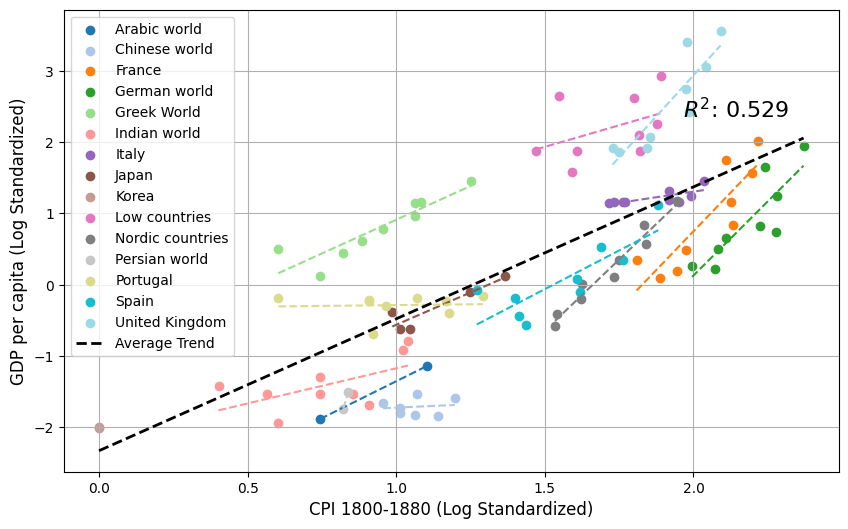

In [15]:

cmap = plt.get_cmap('tab20')
unique_regions = df_ols['region_name'].unique()
colors = cmap(np.linspace(0, 1, len(unique_regions)))
color_map = dict(zip(unique_regions, colors))

plt.figure(figsize=(10, 6))

# Plot individual data points and fit a regression line for each region
for name, group in df_ols.groupby('region_name'):
    # Fit OLS model for each region
    individual_ols_model = smf.ols("log_gdp_std ~ score_log_std", data=group).fit()
    
    # Plotting the scatter for each group
    plt.scatter(group['score_log_std'], group['log_gdp_std'], color=color_map[name], label=name)
    
    # Calculating the regression line
    x_vals = np.linspace(group['score_log_std'].min(), group['score_log_std'].max(), 100)
    y_vals = individual_ols_model.params['Intercept'] + individual_ols_model.params['score_log_std'] * x_vals
    plt.plot(x_vals, y_vals, 'k--', color=color_map[name], label=None)

# Fit a global OLS model to get the average trend line
average_ols_model = smf.ols("log_gdp_std ~ score_log_std", data=df_ols).fit()

# Calculate and plot the average trend line
x_vals_global = np.linspace(df_ols['score_log_std'].min(), df_ols['score_log_std'].max(), 100)
y_vals_global = average_ols_model.params['Intercept'] + average_ols_model.params['score_log_std'] * x_vals_global
plt.plot(x_vals_global, y_vals_global, 'k--', label='Average Trend', linewidth=2)

plt.legend()
plt.xlabel('CPI 1800-1880 (Log Standardized)', fontsize=12)
plt.ylabel('GDP per capita (Log Standardized)', fontsize=12)
plt.title('')
plt.grid(True)

# Display R-squared for the average trend line
r_squared = average_ols_model.rsquared
plt.figtext(0.85, 0.7, f'$R^2$: {r_squared:.3f}', ha='right', fontsize=16)

plt.show()

#### Stats Table

In [16]:
final_table = pd.concat(tables_dict.values(), ignore_index=True).reset_index(drop=True)
final_table = final_table[final_table['index']=='alpha']
final_table = final_table.drop(['index', 'z'], axis=1)
final_table = final_table.sort_values('Coef.', ascending=True)
final_table = final_table.rename(columns={'[0.025':'0.025', '0.975]':'0.975'})
list(final_table.columns)

final_table['Coef.'] = final_table['Coef.'].astype(float)
final_table['0.025'] = final_table['0.025'].astype(float)
final_table['0.975'] = final_table['0.975'].astype(float)
final_table['P>|z|'] = final_table['P>|z|'].astype(float)
final_table = final_table.reset_index(drop=True)
final_table['model'] = final_table['model'] + ' vs GDP per Capita'
final_table

,Coef.,Std.Err.,P>|z|,0.025,0.975,model
0,0.472,0.030,0.0,0.414,0.531,Corrected CPI vs GDP per Capita
1,0.871,0.051,0.0,0.772,0.970,CPI vs GDP per Capita
2,1.228,0.120,0.0,0.993,1.463,Corrected CPI 1800-1880 vs GDP per Capita
3,1.950,0.194,0.0,1.570,2.330,CPI 1800-1880 vs GDP per Capita


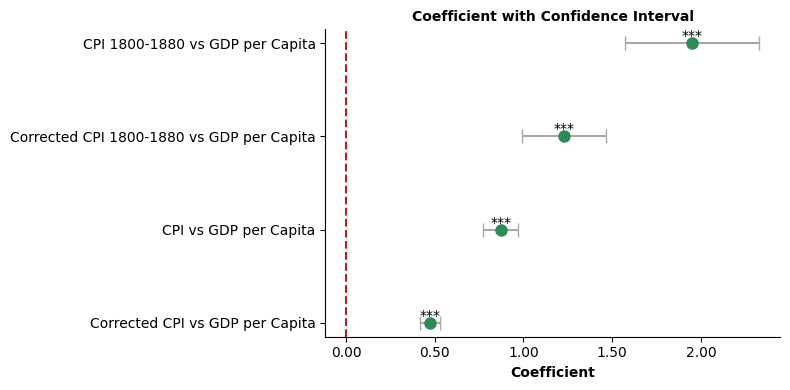

In [17]:
fig, ax = plt.subplots(figsize=(8, 4))  # Increased figure size for more models

# Plot the data points and error bars
ax.errorbar(final_table['Coef.'], final_table['model'], 
            xerr=[final_table['Coef.'] - final_table['0.025'], 
                  final_table['0.975'] - final_table['Coef.']],
            fmt='o', capsize=5, ecolor='darkgray', markersize=8, 
            color='seagreen', linewidth=1.5, zorder=2)

# Add a vertical line at x=0
ax.axvline(x=0, color='firebrick', linestyle='--', linewidth=1.5, zorder=1)

# Add *** on top of the green dots
for i, model in enumerate(final_table['model']):
    ax.text(final_table['Coef.'][i], model, '***', ha='center', va='bottom', color='black', fontsize=10)

# Customize the plot
ax.set_xlabel('Coefficient', fontweight='bold')
ax.set_ylabel('', fontweight='bold')
ax.set_title('Coefficient with Confidence Interval', fontsize=10, fontweight='bold')

# Adjust the x-axis to show more precision
ax.xaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: f"{x:.2f}"))

# Remove top and right spines for a cleaner look
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

# Adjust layout and display the plot
plt.tight_layout()
plt.show()

### Population data

###  Checking for multicolinearity

In [18]:
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.tools.tools import add_constant

# Assuming 'df' is your DataFrame and it contains all relevant predictors
X = add_constant(df[['N_est_log_std', 'pop_log_std']])  # adding a constant is essential for VIF calculation

VIF = pd.DataFrame()
VIF["Variable"] = X.columns
VIF["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
print(VIF)


        Variable       VIF
0          const  1.000000
1  N_est_log_std  1.008684
2    pop_log_std  1.008684


In [19]:
# Assuming 'df' is your DataFrame
correlation_matrix = df[['N_est_log_std', 'pop_log_std']].corr()
correlation_matrix

,N_est_log_std,pop_log_std
N_est_log_std,1.000000,0.092785
pop_log_std,0.092785,1.000000


In [20]:
list(df.columns)

['region_name',
 'year',
 'gdp_per_capita',
 'pop',
 'N_est',
 'score',
 'survival_ratio',
 'score_cap',
 'N_est_cap',
 'century',
 'score_log',
 'score_cap_log',
 'N_est_log',
 'N_est_cap_log',
 'score_log_std',
 'score_cap_log_std',
 'N_est_std',
 'N_est_log_std',
 'N_est_cap_log_std',
 'log_gdp',
 'log_gdp_std',
 'gdp_std',
 'survival_ratio_std',
 'pop_log',
 'pop_log_std']

In [21]:
df_ols_pop = df[['region_name', 'year', 'log_gdp_std', 'N_est_log_std', 'score_log_std', 'pop_log_std']].copy()

# Mixed Effects Model
model = smf.mixedlm("log_gdp_std ~ N_est_log_std + pop_log_std", df_ols_pop, groups=df_ols_pop["region_name"])
result = model.fit()

print(result.summary())

result

          Mixed Linear Model Regression Results
Model:            MixedLM Dependent Variable: log_gdp_std
No. Observations: 514     Method:             REML       
No. Groups:       16      Scale:              0.2334     
Min. group size:  1       Log-Likelihood:     -396.9452  
Max. group size:  64      Converged:          Yes        
Mean group size:  32.1                                   
---------------------------------------------------------
               Coef.  Std.Err.   z    P>|z| [0.025 0.975]
---------------------------------------------------------
Intercept      -0.349    0.316 -1.103 0.270 -0.969  0.271
N_est_log_std   0.242    0.045  5.400 0.000  0.154  0.330
pop_log_std     0.696    0.106  6.586 0.000  0.489  0.904
Group Var       1.562    1.302                           



In [22]:
# sm_table.index = ['Intercept', 'CCPI', "Population",'Group Var']
# sm_table['model'] = 'Corrected CPI'
# sm_table = sm_table.reset_index()

# # Plotting the summary text
# fig, ax = plt.subplots(figsize=(8, 6))
# ax.text(0.5, 0.5, result.summary(), fontsize=12, va='center', ha='center', fontname='Monospace')
# ax.axis('off')  # Turn off the axis

# # plt.savefig('model_summary_pop_ccpi.png', dpi=300, bbox_inches='tight', pad_inches=0.5)

In [23]:
# # Mixed Effects Model
# model = smf.mixedlm("log_gdp_std ~ score_log_std + pop_log_std", df_ols_pop, groups=df_ols_pop["region_name"])
# result = model.fit()

# print(result.summary())

# sm_table = result.summary().tables[1]
# sm_table.index = ['Intercept', 'CPI', "Population",'Group Var']
# sm_table['model'] = 'Corrected CPI'
# sm_table = sm_table.reset_index()

# # Plotting the summary text
# fig, ax = plt.subplots(figsize=(8, 6))
# ax.text(0.5, 0.5, result.summary(), fontsize=12, va='center', ha='center', fontname='Monospace')
# ax.axis('off')  # Turn off the axis

# plt.savefig('model_summary_pop_cpi.png', dpi=300, bbox_inches='tight', pad_inches=0.5)